<h1><center>IAML LAB 2: ATTRIBUTE SELECTION & REGRESSION </center></h1>

In [1]:
from scipy.io import arff
from scipy.stats import pearsonr
import pandas as pd

from utils import update_plot_params, cv2df

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_fscore_support
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from IPython.display import HTML

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(palette="Set2")

In [2]:
update_plot_params()

In [3]:
styles = [
    dict(selector="th", props=[("font-size", "100%"),
                               ("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

## LANDSAT DATA 

In [4]:
data, _ = arff.loadarff('./data/raw/landsat.arff.txt')
landsat = pd.DataFrame(data)

landsat['class'] = landsat['class'].str.decode('utf-8').astype(int)

### Features  correlation

In [5]:
cm = ListedColormap(sns.color_palette("RdYlGn", 100).as_hex())

s = landsat.corr().loc[:, ['class']].sort_values('class', ascending=False)
s = s.style.background_gradient(cmap=cm)

In [6]:
s

,class
class,1
pixel9_1,0.147058
pixel3_1,0.141965
pixel6_1,0.137935
pixel8_1,0.136048
pixel7_1,0.135234
pixel2_1,0.13242
pixel5_1,0.129212
pixel1_1,0.125741
pixel4_1,0.124539


In [7]:
y = landsat.pop('class')
X = landsat

### Train model 

In [8]:
naive_bayes = MultinomialNB()

The data has a multi-label representation. Because of sequence of sequences are no longer supported in **sklearn.model_selection.cross_validate**; use a binary array or sparse matrix instead.

In [9]:
tuples = [tuple(x) for x in X.values]

mlb = MultiLabelBinarizer()
binarized_X = mlb.fit_transform(tuples)

In [10]:
scores = cross_validate(naive_bayes, binarized_X, y,
                        scoring=['accuracy', 'precision_macro',
                                 'recall_macro', 'f1_macro'],
                        cv=5, return_train_score=True)

In [11]:
# Transpose to improve perception
cv2df(scores, True, 6).T.style.set_table_styles(styles)

n_folds,1,2,3,4,5,Mean
fit_time,0.0159354,0.00444412,0.00318122,0.00365996,0.00503612,0.00645137
score_time,0.00667214,0.00308681,0.00291872,0.00285196,0.00301909,0.00370975
test_accuracy,0.84027,0.779279,0.758737,0.662528,0.655367,0.739236
test_f1_macro,0.827895,0.746068,0.71063,0.662811,0.642137,0.717908
test_precision_macro,0.825807,0.74469,0.730019,0.681476,0.668354,0.730069
test_recall_macro,0.843957,0.750748,0.712862,0.676458,0.658619,0.728529
train_accuracy,0.761421,0.773612,0.767193,0.7898,0.790423,0.77649
train_f1_macro,0.738437,0.755631,0.751965,0.766303,0.771273,0.756722
train_precision_macro,0.740092,0.757044,0.752624,0.767723,0.771692,0.757835
train_recall_macro,0.745303,0.763775,0.762188,0.773139,0.778747,0.76463


### Select most significant features and train model again

In [12]:
selected_X = X.loc[:, ['pixel5_2','pixel5_4']].astype(int)
tuples = [tuple(x) for x in selected_X.values]

mlb = MultiLabelBinarizer()
binarized_X = mlb.fit_transform(tuples)

In [13]:
scores = cross_validate(naive_bayes, binarized_X, y,
                        scoring=['accuracy', 'precision_macro',
                                 'recall_macro', 'f1_macro'],
                        cv=5, return_train_score=True)

In [14]:
cv2df(scores, True, 6).T.style.set_table_styles(styles)

n_folds,1,2,3,4,5,Mean
fit_time,0.0123537,0.00441551,0.00295424,0.00284195,0.00300074,0.00511322
score_time,0.00977707,0.00339389,0.00291371,0.00298691,0.00281191,0.0043767
test_accuracy,0.541057,0.60473,0.537768,0.493228,0.497175,0.534792
test_f1_macro,0.553976,0.559124,0.514836,0.48712,0.493869,0.521785
test_precision_macro,0.595137,0.591735,0.575512,0.551433,0.550298,0.572823
test_recall_macro,0.545153,0.567881,0.512689,0.476416,0.486222,0.517672
train_accuracy,0.602087,0.599662,0.605411,0.62891,0.612958,0.609805
train_f1_macro,0.579406,0.594324,0.603342,0.619289,0.604328,0.600138
train_precision_macro,0.645622,0.641499,0.653103,0.675196,0.64171,0.651426
train_recall_macro,0.568724,0.581941,0.587592,0.602634,0.590691,0.586317


## Attribute Selection via Information Gain 

In [15]:
information_gain = dict(zip(X.columns, mutual_info_classif(X, y, discrete_features=True)))
information_gain = pd.DataFrame(data=information_gain, index=['Information gain']).T

In [16]:
information_gain.sort_values('Information gain', ascending=False)

,Information gain
pixel5_2,0.827737
pixel5_1,0.813325
pixel6_2,0.770574
pixel6_1,0.768198
pixel4_2,0.746105
pixel4_1,0.735423
pixel5_4,0.734714
pixel2_2,0.720470
pixel8_2,0.719593
pixel8_1,0.719548


Plot **pixel6_1** against **pixel5_1**, and **pixel6_2** against **pixel5_2**. 

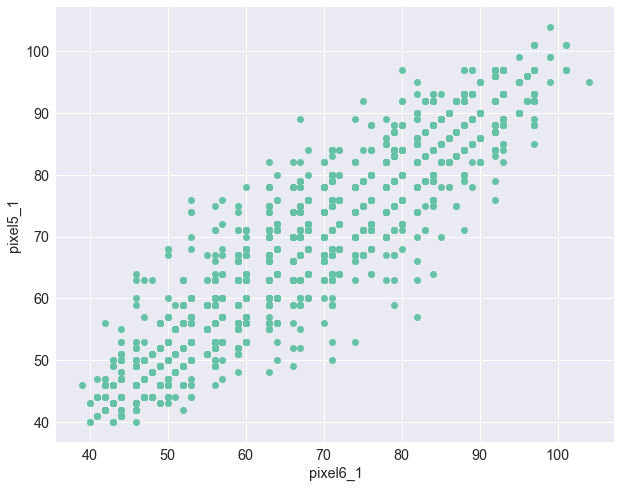

In [17]:
plt.plot(X['pixel6_1'], X['pixel5_1'], 'o')
plt.xlabel('pixel6_1')
plt.ylabel('pixel5_1')
plt.show()

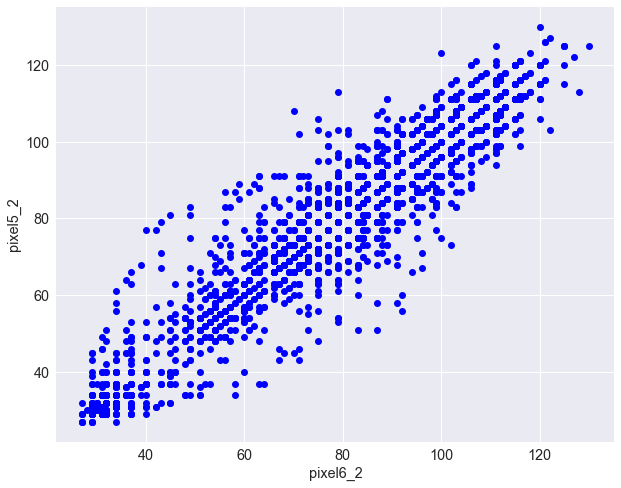

In [18]:
plt.plot(X['pixel6_2'], X['pixel5_2'], color="b", marker='o', linewidth=0)
plt.xlabel('pixel6_2')
plt.ylabel('pixel5_2')
plt.show()

### Select first 10 features to train model

In [19]:
selected_features = list(information_gain.sort_values('Information gain', ascending=False).iloc[:10].index)

In [20]:
selected_X = X[selected_features].astype(int)
tuples = [tuple(x) for x in selected_X.values]

mlb = MultiLabelBinarizer()
binarized_X = mlb.fit_transform(tuples)

In [21]:
scores = cross_validate(naive_bayes, binarized_X, y,
                        scoring=['accuracy', 'precision_macro',
                                 'recall_macro', 'f1_macro'],
                        cv=5, return_train_score=True)

In [22]:
cv2df(scores, True, 6).T.style.set_table_styles(styles)

n_folds,1,2,3,4,5,Mean
fit_time,0.00929403,0.00346756,0.00339055,0.00287127,0.00432086,0.00466886
score_time,0.00502229,0.00326419,0.00332117,0.00306058,0.00276351,0.00348635
test_accuracy,0.830146,0.807432,0.770011,0.691874,0.668927,0.753678
test_f1_macro,0.815256,0.764733,0.717499,0.688766,0.660966,0.729444
test_precision_macro,0.820214,0.77807,0.740586,0.710542,0.687346,0.747351
test_recall_macro,0.821917,0.760149,0.73052,0.704965,0.677326,0.738975
train_accuracy,0.776086,0.782915,0.775085,0.791772,0.8,0.785172
train_f1_macro,0.752423,0.76462,0.759904,0.769266,0.777747,0.764792
train_precision_macro,0.757116,0.76904,0.764643,0.774758,0.782335,0.769579
train_recall_macro,0.754592,0.768044,0.766199,0.770618,0.778805,0.767652


## CPU PERFORMANCE 

In [23]:
data, _ = arff.loadarff('./data/raw/cpu.arff.txt')
cpu = pd.DataFrame(data)

cpu['vendor'] = cpu['vendor'].str.decode('utf-8')
vendor = cpu['vendor']

In [24]:
cpu = cpu.drop(columns=['vendor'])

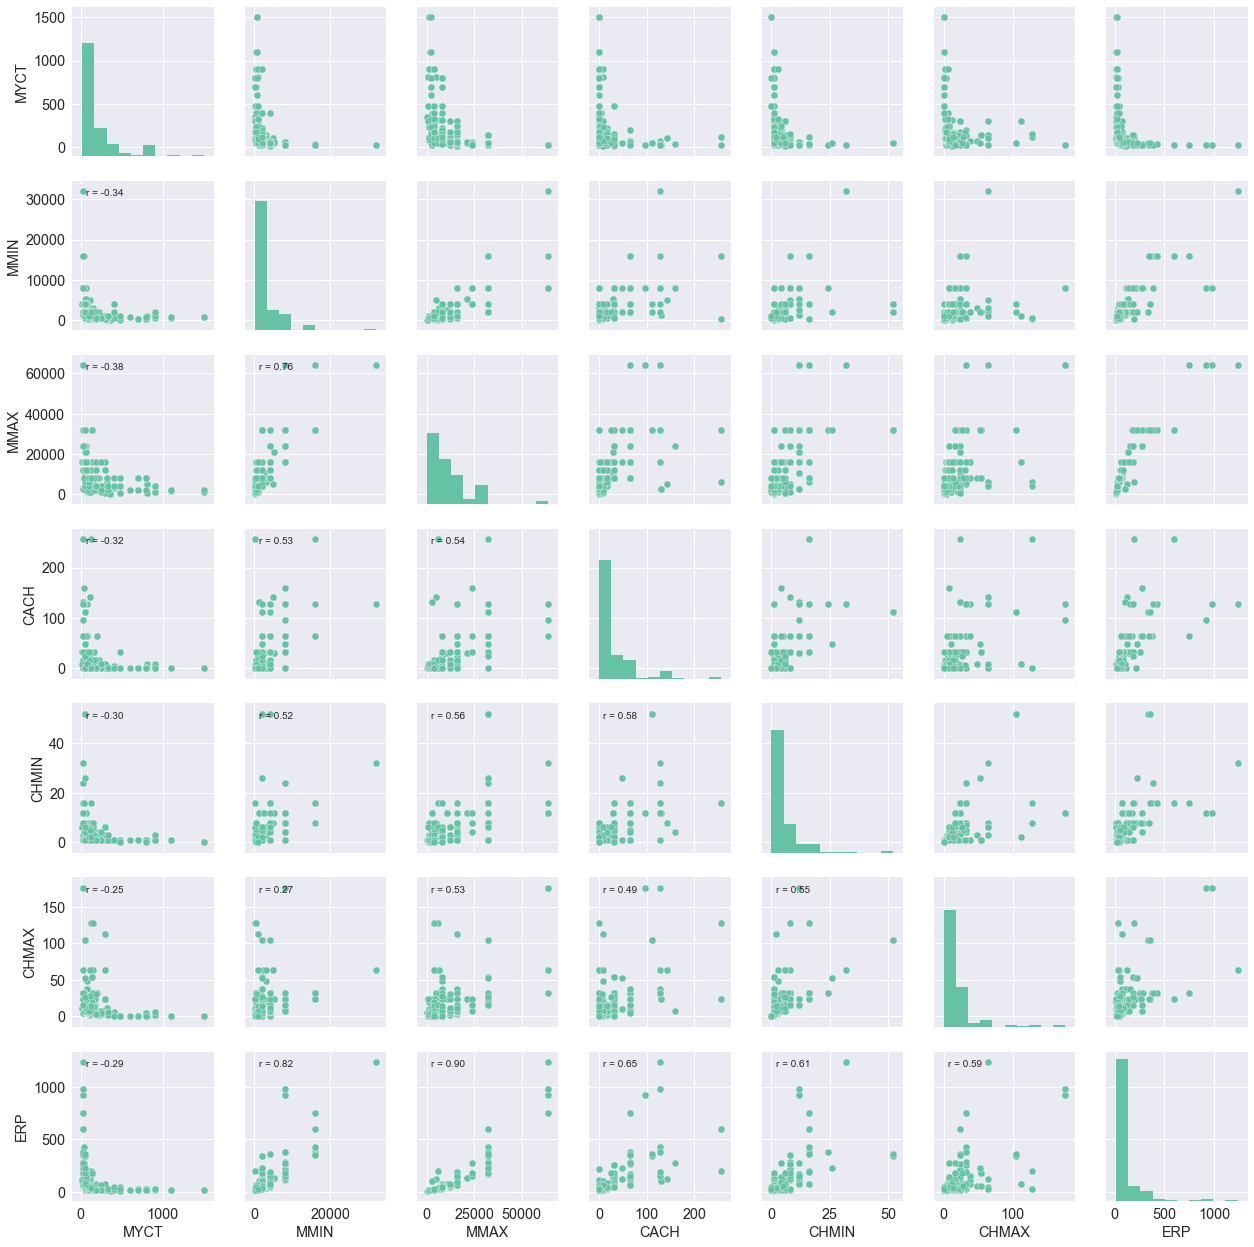

In [25]:
def corrfunc(x, y, **kws):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .9), xycoords=ax.transAxes)
    
g = sns.pairplot(cpu)
g.map_lower(corrfunc)
plt.savefig('./plots/cpu_pairplot.png', dpi=200)
plt.show()

In [26]:
y = cpu.pop('ERP')
X = cpu

### Train model 

#### Linear Regression 

In [27]:
lin_regr = LinearRegression()

In [28]:
scores = cross_validate(lin_regr, X, y,
                        scoring=['explained_variance', 'neg_mean_absolute_error', 
                                 'neg_mean_squared_error', 'r2'],
                        cv=10, return_train_score=True)

In [29]:
cv2df(scores, True, 11).abs().T.style.set_table_styles(styles)

n_folds,1,2,3,4,5,6,7,8,9,10,Mean
fit_time,0.00408697,0.00305939,0.00281763,0.00191545,0.00145793,0.00129318,0.00102806,0.00128555,0.000989914,0.000976801,0.00189109
score_time,0.0029428,0.00254321,0.00221968,0.00141144,0.00122333,0.00117755,0.00100827,0.000991583,0.000860691,0.000869513,0.00152481
test_explained_variance,0.823622,0.177274,0.132456,0.924371,0.778831,0.204775,0.291584,0.919017,0.82549,0.745105,0.277116
test_neg_mean_absolute_error,63.8208,36.0821,15.2499,35.0112,45.2876,21.0497,22.6325,39.3058,25.2774,66.1599,36.9877
test_neg_mean_squared_error,14730.6,1636.89,332.998,2359.87,3013.38,691.122,1118.94,1933.1,894.353,20698.9,4741.02
test_r2,0.820028,0.255229,0.236609,1.00243,0.728706,0.110133,0.350398,0.908309,0.770306,0.71979,0.221261
train_explained_variance,0.910294,0.915922,0.910638,0.917876,0.917968,0.911286,0.914428,0.909696,0.912343,0.925824,0.914627
train_neg_mean_absolute_error,24.5465,32.5917,34.4218,32.5491,32.7523,34.1518,33.388,32.2618,33.7553,21.8033,31.2221
train_neg_mean_squared_error,1387.51,2194.66,2326.2,2135.91,2071.74,2307.95,2249.01,2157.65,2268.26,1254.25,2035.31
train_r2,0.910294,0.915922,0.910638,0.917876,0.917968,0.911286,0.914428,0.909696,0.912343,0.925824,0.914627


#### K-nearest neighbors

In [30]:
knn = KNeighborsRegressor()

In [31]:
scores = cross_validate(knn, X, y, 
                        scoring=['explained_variance', 'neg_mean_absolute_error', 
                                 'neg_mean_squared_error', 'r2'], 
                        cv=10, return_train_score=True) 

In [32]:
cv2df(scores, True, 11).abs().T.style.set_table_styles(styles)

n_folds,1,2,3,4,5,6,7,8,9,10,Mean
fit_time,0.00287986,0.0022583,0.00134969,0.000955582,0.000821114,0.000727892,0.000981569,0.000767469,0.000745296,0.000851154,0.00123379
score_time,0.0060792,0.00537682,0.00315499,0.0022676,0.00227451,0.00166535,0.00185347,0.00195312,0.00174356,0.00184631,0.00282149
test_explained_variance,0.76058,0.309141,0.945691,0.644614,0.890474,0.904657,0.929733,0.875125,0.766534,0.810621,0.783717
test_neg_mean_absolute_error,56.2952,16.781,4.2,12.4857,25.7238,5.65714,6.57143,22.6762,12.819,63.73,22.694
test_neg_mean_squared_error,21734.4,901.623,27.9295,418.912,1828.3,75.1467,73.92,2907,1028.99,17443.2,4643.94
test_r2,0.73446,0.308603,0.896282,0.64454,0.835399,0.903244,0.910789,0.862114,0.735726,0.763864,0.759502
train_explained_variance,0.867201,0.944666,0.941541,0.941695,0.941049,0.941644,0.941203,0.940882,0.943455,0.853109,0.925645
train_neg_mean_absolute_error,13.0351,12.4564,13.8809,13.4649,13.7021,13.6043,13.9936,12.7266,13.0372,12.8148,13.2716
train_neg_mean_squared_error,2114,1487.23,1571.2,1560.87,1515.8,1567.42,1588.83,1454.41,1501.59,2519.76,1688.11
train_r2,0.863324,0.943024,0.939642,0.939986,0.93998,0.939751,0.939547,0.939129,0.941971,0.850983,0.923734


### Add vendor attribute

In [33]:
vendor = vendor.astype('category').cat.codes

In [34]:
enc = OneHotEncoder()
binarized_vendor = enc.fit_transform(vendor.values.reshape(cpu.shape[0],1))  
binarized_vendor = binarized_vendor.toarray()

In [35]:
vendor = pd.DataFrame(data=binarized_vendor, columns=['vendor_{}'.format(x) for x in enc.active_features_])

In [36]:
cpu = pd.concat([cpu, vendor], axis=1)

In [37]:
cpu.shape

(209, 36)

### Train model 

#### Linear Regression 

In [38]:
X = cpu

In [39]:
scores = cross_validate(lin_regr, X, y, 
                        scoring=['explained_variance', 'neg_mean_absolute_error', 
                                 'neg_mean_squared_error', 'r2'], 
                        cv=10, return_train_score=True) 

In [40]:
cv2df(scores, True, 11).abs().T.style.set_table_styles(styles)

n_folds,1,2,3,4,5,6,7,8,9,10,Mean
fit_time,0.0026989,0.00181389,0.0022347,0.00257373,0.00191712,0.00182652,0.00160789,0.00186634,0.00132227,0.00170946,0.00195708
score_time,0.00122285,0.00120687,0.00122976,0.00132275,0.00111103,0.000964165,0.000848532,0.000941515,0.0007658,0.00083518,0.00104485
test_explained_variance,0.786671,0.182963,0.518425,1.81846,0.669584,0.56708,1.88501,0.882527,0.700267,0.679729,0.125316
test_neg_mean_absolute_error,76.5903,36.068,19.4032,41.3867,49.8361,31.1165,36.489,42.0812,37.6856,66.9079,43.7565
test_neg_mean_squared_error,18538,1706.25,536.988,3469.12,3726.44,1334.6,2393.88,2485.56,2005.98,25530.5,6172.73
test_r2,0.773512,0.308417,0.994138,1.94365,0.66451,0.718395,1.88908,0.882104,0.484809,0.654383,0.239436
train_explained_variance,0.940328,0.93224,0.92841,0.937997,0.937588,0.931061,0.932414,0.928835,0.931118,0.937139,0.933713
train_neg_mean_absolute_error,19.65,28.3298,30.0965,27.1491,27.4126,29.5917,28.5896,27.6959,28.6215,19.317,26.6454
train_neg_mean_squared_error,922.967,1768.73,1863.56,1612.59,1576.21,1793.47,1776.3,1700.36,1782.42,1062.94,1585.95
train_r2,0.940328,0.93224,0.92841,0.937997,0.937588,0.931061,0.932414,0.928835,0.931118,0.937139,0.933713


### K-nearest neighbors 

In [41]:
scores = cross_validate(knn, X, y, 
                        scoring=['explained_variance', 'neg_mean_absolute_error', 
                                 'neg_mean_squared_error', 'r2'], 
                        cv=10, return_train_score=True) 

In [42]:
cv2df(scores, True, 11).abs().T.style.set_table_styles(styles)

n_folds,1,2,3,4,5,6,7,8,9,10,Mean
fit_time,0.00445533,0.00118804,0.000850439,0.00107288,0.000805616,0.000820875,0.00105309,0.00109005,0.000943184,0.000756979,0.00130365
score_time,0.00940943,0.00420094,0.00226569,0.00224805,0.00279856,0.00204253,0.00280261,0.00208449,0.002141,0.00190568,0.0031899
test_explained_variance,0.76058,0.309141,0.945691,0.644614,0.890474,0.904657,0.929733,0.875125,0.766534,0.810621,0.783717
test_neg_mean_absolute_error,56.2952,16.781,4.2,12.4857,25.7238,5.65714,6.57143,22.6762,12.819,63.73,22.694
test_neg_mean_squared_error,21734.4,901.623,27.9295,418.912,1828.3,75.1467,73.92,2907,1028.99,17443.2,4643.94
test_r2,0.73446,0.308603,0.896282,0.64454,0.835399,0.903244,0.910789,0.862114,0.735726,0.763864,0.759502
train_explained_variance,0.867176,0.944666,0.941529,0.941684,0.941049,0.941632,0.941203,0.940882,0.943455,0.853109,0.925639
train_neg_mean_absolute_error,13.0021,12.4564,13.8479,13.4319,13.7021,13.5713,13.9936,12.7266,13.0372,12.8148,13.2584
train_neg_mean_squared_error,2113.74,1487.23,1570.94,1560.61,1515.8,1567.16,1588.83,1454.41,1501.59,2519.76,1688.01
train_r2,0.863341,0.943024,0.939651,0.939996,0.93998,0.93976,0.939547,0.939129,0.941971,0.850983,0.923738
